## Introduction 

Recovering true correlation coefficient in the context of single-cell or spatial RNA-seq data can be a challenging task due to the sparse nature of genomic measurements. Spearman and Pearson measures are long standing go-to methods for estimating correlation coefficients for any two vectors of numbers. However for single-cell transcriptomics and more recently for spatial transcriptomics we have more information of the underlying dataset, for example, we know that the underlying data is always integers, moreover each cell/spot expresses a fixed number of total UMI counts that is distributed over the genes that are expressed. These two observation can be incorporated in a better estimation of the correlation coefficient. 

## Simulation 
To view this in action we will demonstrate the copula in effect via simulation. 

In [1]:
!pwd

/Users/hs0424/Workspace/copulacci/notebook/tutorial


In [109]:
# Squidpy for getting dataset
import squidpy as sq
import pandas as pd
import spatialdm as sdm
import scanpy as sc
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from joblib import Parallel, delayed
import tqdm

In [108]:
from copulacci import cci
from copulacci import spatial
from copulacci import model
from copulacci import simulation
from copulacci import model2

In [110]:
!pwd

/Users/hs0424/Workspace/copulacci/notebook/tutorial


In [3]:
adata = sq.datasets.visium(sample_id='V1_Breast_Cancer_Block_A_Section_1')

  0%|          | 0.00/9.50M [00:00<?, ?B/s]

  0%|          | 0.00/26.9M [00:00<?, ?B/s]

/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
annotation_meta = pd.read_csv(
    'data/Human_Breast_Cancer_Metadata.tsv',
    sep = '\t',
    index_col=0
)

In [9]:
adata.obs = adata.obs.join(annotation_meta)

In [19]:
adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

In [85]:
n_array_sum = adata.to_df().sum(1)

In [37]:
!pwd

/Users/hs0424/Workspace/copulacci/notebook/tutorial


## Run overall sdm to exatract LR pairs (needed for simulation )

In [29]:
adata.var_names_make_unique()

In [30]:
adata_sdm = adata.copy()

In [32]:
sc.pp.normalize_total(adata_sdm, target_sum=None)
sc.pp.log1p(adata_sdm)

In [33]:
adata_sdm

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'old_annot_type', 'old_fine_annot_type', '1', '2', '3', '4', '5', 'scaled_x', 'scaled_y', 'fine_annot', 'annot', 'fine_annot_type', 'ground_truth', 'annot_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

In [34]:
sdm.extract_lr(adata_sdm, 'human', min_cell=20)

In [46]:
df_lig_rec_linear = cci.extract_lig_rec_from_sdm(adata_sdm, allow_same_lr=True)
chosen_lr = list(set( df_lig_rec_linear.ligand.unique()).union(
    set( df_lig_rec_linear.receptor.unique() )
))
count_df = adata.to_df().loc[:,chosen_lr]

In [48]:
count_df.sum(1).head()

AAACAAGTATCTCCCA-1     764.0
AAACACCAATAACTGC-1    1570.0
AAACAGAGCGACTCCT-1     207.0
AAACAGGGTCTATATT-1    1184.0
AAACAGTGTTCCTGGG-1    2186.0
dtype: float32

In [50]:
adata.obs['celltype'] = adata.obs.annot_type
adata_sdm.obs['celltype'] = adata.obs.annot_type

In [51]:
int_edges_new, int_edges_with_selfloop = spatial.construct_boundary(
    adata_sdm
)

Constructing spatial network with visium


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3798/3798 [00:00<00:00, 18756.19it/s]


In [53]:
lig_list = adata_sdm.uns['ligand'].values
rec_list = adata_sdm.uns['receptor'].values
df_lig_rec = pd.concat(
   [ adata_sdm.uns['ligand'], adata_sdm.uns['receptor']],
    axis = 1
)
data_list_dict, umi_sums, dist_list_dict = spatial.prepare_data_list(
    count_df,
    int_edges_with_selfloop,
    heteromeric=True,
    lig_list=lig_list,
    rec_list = rec_list,
    summarization='sum'
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


### Estimate empirical $\mu_g$ for genes

/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


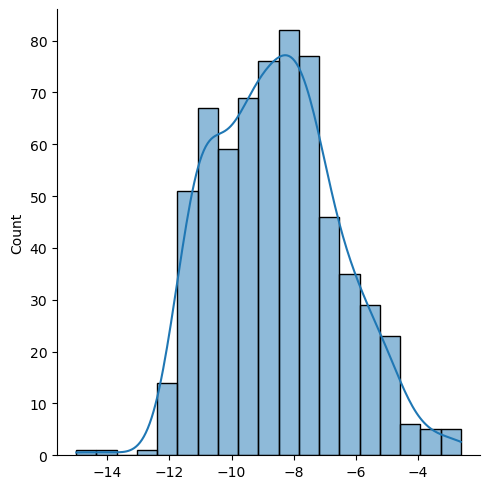

In [58]:
sns.displot(np.log(count_df.sum(0) / count_df.sum(1).sum()).replace([np.inf,-np.inf], np.nan).dropna(),kde=True, kind="hist");

## Match the distrubution and sample $\mu_\ell$ and $\mu_r$ for simulating copula data

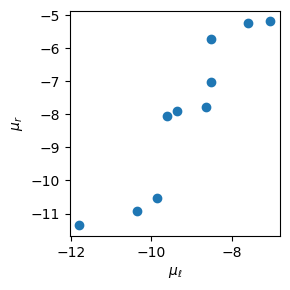

In [80]:
np.random.seed(2)
mu_x_vals = np.random.uniform(-12, -4, 10)
mu_y_vals = np.random.uniform(-12, -4, 10)
mu_x_vals = sorted(mu_x_vals)
mu_y_vals = sorted(mu_y_vals)
plt.figure(figsize=(3,3))
plt.scatter(mu_x_vals, mu_y_vals)
plt.xlabel('$\mu_\ell$')
plt.ylabel('$\mu_r$');
plt.tight_layout();

### Sumulate 500 samples

In [81]:
grid_points_df = simulation.create_param_grid(mu_x_vec = mu_x_vals, mu_y_vec = mu_y_vals)
grid_points_df_sampled = grid_points_df.sample(500).sort_index()

In [86]:
pseudo_count = pd.DataFrame()
for row in tqdm.tqdm(grid_points_df_sampled.iterrows()):
    sparse_frac, mu_x, mu_y, rho, global_idx = row[1]
    _n_array = (n_array_sum * sparse_frac).astype('int')
    
    
    sample = model2.sample_from_copula(
        _n_array,
        mu_x, 
        mu_y, 
        coeff = rho
    )
    sample.columns = ['L'+str(int(global_idx)), 'R'+str(int(global_idx))]
    pseudo_count = pd.concat([pseudo_count, sample.copy()], axis = 1)

500it [00:06, 82.49it/s] 


## Measure the sparsity of the data

In [87]:
idx = 0
sum_cols = []
for i in range(0, len(pseudo_count.columns), 2):
    # Extract the current and next columns
    current_col = np.concatenate([pseudo_count.iloc[:, i].values, 
                                  pseudo_count.iloc[:, i+1].values])

    # Calculate the sum of the two consecutive columns
    sum_cols += [pd.DataFrame(current_col, columns = ['LR'+str(idx)])]
    idx += 1

In [88]:
sparse_res_df = pd.concat(sum_cols, axis = 1)
results_df = grid_points_df_sampled.copy()
results_df.loc[:,'zero_ratio'] = (sparse_res_df == 0).mean().values

## Prepare data so that we can run copula in parallel threads

In [89]:
data_list = []
i = 0
for row in tqdm.tqdm(grid_points_df_sampled.iterrows()):
    sparse_frac, mu_x, mu_y, rho, i = row[1]
    _n_array = (n_array_sum * sparse_frac).astype('int')
    data_list += [
        (
            pseudo_count.loc[:, 'L'+str(int(i))].values.astype('int'),
            pseudo_count.loc[:, 'R'+str(int(i))].values.astype('int'),
            mu_x, mu_y,
            _n_array.copy()
            
        )
    ]

500it [00:00, 4356.28it/s]


### How sparse the simulated count data is?

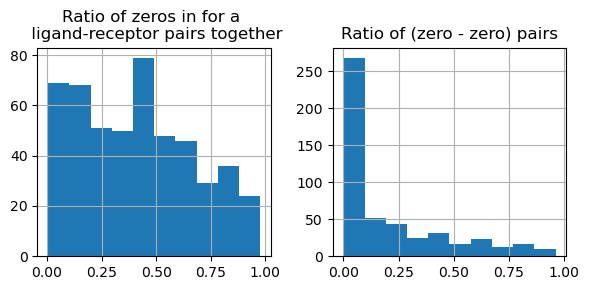

In [92]:
zz_pair_list = []
for (x,y,_,_,_n_array) in data_list:
    zz_pair = ((x == 0) & (y == 0)).sum()
    zz_pair_list += [zz_pair / len(x)]
results_df.loc[:,'zz_ratio'] = zz_pair_list
fig, ax = plt.subplots(1,2,figsize=(6,3))
results_df.zero_ratio.hist(ax=ax[0]);
results_df.zz_ratio.hist(ax=ax[1]);
ax[0].set_title('Ratio of zeros in for a \n ligand-receptor pairs together')
ax[1].set_title('Ratio of (zero - zero) pairs')
plt.tight_layout();

## Run spearman and pearson on log normalized count data

In [95]:
count_df_norm = pseudo_count.div(pseudo_count.sum(1), axis = 0) 
count_df_norm_log = np.log( count_df_norm + 1 )
data_list_log = []
for row in tqdm.tqdm(grid_points_df_sampled.iterrows()):
    sparse_frac, mu_x, mu_y, rho, i = row[1]
    data_list_log += [
        (
            count_df_norm_log.loc[:, 'L'+str(int(i))],
            count_df_norm_log.loc[:, 'R'+str(int(i))]
        )
    ]
spr = []
for (x,y) in data_list_log:
    spr += [stats.spearmanr(x, y).correlation]
prs = []
for (x,y) in data_list_log:
    prs += [stats.pearsonr(x, y).correlation]

500it [00:00, 12714.25it/s]


In [96]:
results_df = results_df.reset_index().rename(columns={'index':'orig_index'})

## Run copula with 50 restarts and Nelder-Mead optimization

In [99]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
opt_params = opt_params._replace(num_starts=50)

opt_res = Parallel(n_jobs=20, verbose=1)(
    delayed(model2.call_optimizer)(
        x,
        y,
        _n_array,
        _n_array,
        copula_params,
        opt_params,
        use_zero_cutoff = True,
        zero_cutoff = 0.8
    ) for (x,y,_,_,_n_array) in data_list)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    8.6s
[Parallel(n_jobs=20)]: Done 193 tasks      | elapsed:  3.4min
[Parallel(n_jobs=20)]: Done 450 tasks      | elapsed: 11.9min
[Parallel(n_jobs=20)]: Done 500 out of 500 | elapsed: 13.8min finished


In [100]:
cop_res = [opt_res[i][0] for i in range(len(opt_res))]
results_df.loc[:, 'cop'] = cop_res
results_df.loc[:, 'cop_method'] = [opt_res[i][3] for i in range(len(opt_res))]
results_df.loc[:,'spearman_log'] = spr
results_df.loc[:,'pearson_log'] = prs

# Visualize the results

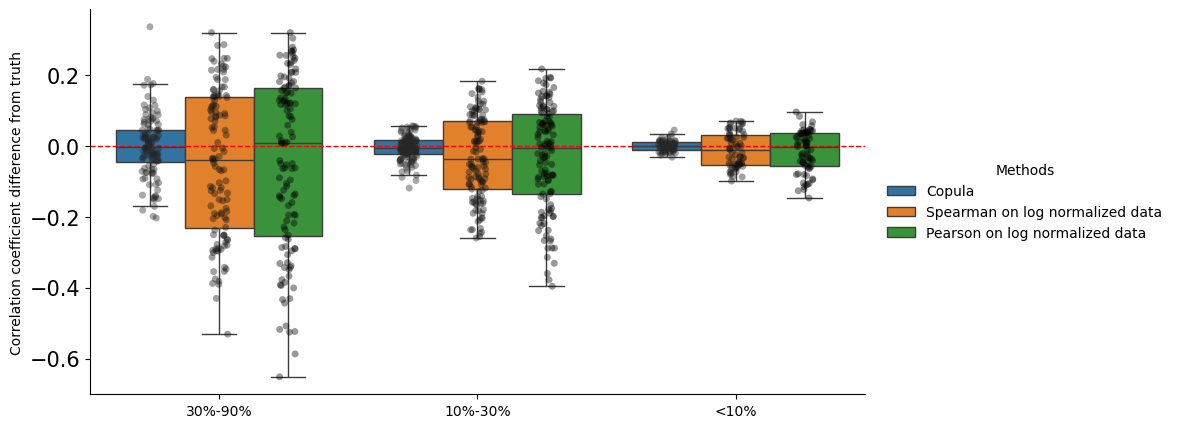

In [105]:
results_filt = results_df.loc[results_df.cop_method == 'copula'].copy()


bins = [0,0.1,0.3,0.6,0.9]
results_filt.loc[:, 'rho_bucket'] = pd.cut(abs(results_filt.rho), bins=bins,
                include_lowest=True,
                labels = ['below_10','10_30','30_60','70_90'])
bins = [0,0.1,0.3,0.9]
labels = ['<10%','10%-30%','30%-90%']
results_filt.loc[:, 'zr_cat'] = pd.cut(results_filt.zero_ratio, bins=bins,
                include_lowest=True,
                labels = labels
                )
results_filt.loc[:, 'zz_cat'] = pd.cut(results_filt.zz_ratio, bins=bins,
                include_lowest=True,
                labels = labels)
res_filt_melt = pd.melt(
    results_filt, 
    id_vars = ['rho','rho_bucket','sparse_frac','zr_cat','zz_cat'],
    value_vars = ['spearman_log', 'pearson_log' , 'cop'],
    var_name = 'method', value_name = 'value'
)

# ---------------------
res_focus = results_filt.copy()
for col in ['spearman_log', 'pearson_log', 'cop',]:
    res_focus.loc[:, col+'_diff'] = res_focus.rho - res_focus[col]

res_focus_melt = pd.melt(
    res_focus, 
    id_vars = ['rho','rho_bucket','sparse_frac','zr_cat','zz_cat'],
    value_vars = ['spearman_log_diff', 'pearson_log_diff', 'cop_diff'],
    var_name = 'method', value_name = 'difference'
)

# ---------------------
plt.figure(figsize=(10, 5))
#figure_backup = '/Users/hs0424/Library/CloudStorage/GoogleDrive-hiraksarkar.cs@gmail.com/My Drive/Manuscripts/2023/Orator_copulacci/ISMB_figures'

#tmp = res_df_melted.loc[res_df_melted.method.isin(['copula_diff', 'spearman_norm_diff', 'spearman_log_norm_diff'])]
label_dict = { 'cop_diff' : 'Copula', 'spearman_diff': 'Spearman', 'pearson_diff' : 'Pearson', 
              'spearman_log_diff': 'Spearman on log normalized data',
              'pearson_log_diff' : 'Pearson on log normalized data'}
sns.stripplot(x="zr_cat", y="difference", hue="method",
              data=res_focus_melt ,
              jitter=True,
              palette='dark:black',
              legend = None,
              hue_order=['cop_diff', 'spearman_log_diff', 'pearson_log_diff'],
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,
              linewidth=0,
              edgecolor='gray',
             order = labels[::-1])

sns.boxplot(x="zr_cat", y="difference", hue="method",
            data=res_focus_melt,
            #palette="Set5",
            hue_order=['cop_diff','spearman_log_diff', 'pearson_log_diff'],
            fliersize=0, 
            order = labels[::-1]
           )

plt.xlabel('', fontsize = 10)
plt.ylabel('Correlation coefficient difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=15)
plt.axhline(y=0, c = 'r', linewidth = 1, linestyle='--')


#leg = plt.gca().get_legend()
leg = plt.legend(
    title="Methods",
                 loc='right', bbox_to_anchor=(1.4,0.5),
          frameon=False);

# Replace the legend labels using the custom handler
for text, handle in zip(leg.texts, leg.legend_handles):
    text.set_text(label_dict.get(text.get_text(), text.get_text()))

plt.setp(leg.texts, fontsize='10')
sns.despine()
# plt.savefig( os.path.join(figure_backup,
#                            'non_spatial_simulation_copula_1_24_24_buckets.pdf'), dpi = 300, bbox_inches='tight')
plt.show()

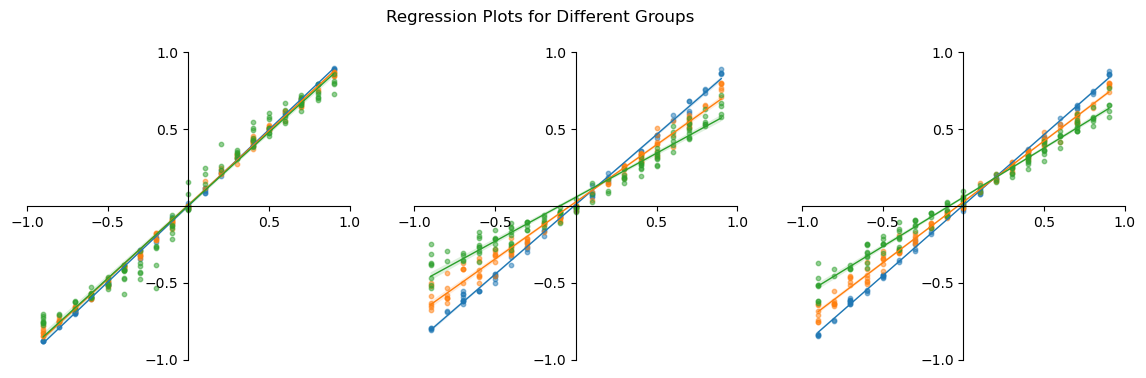

In [103]:
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D

g = sns.FacetGrid(res_filt_melt, col="method", hue="zr_cat", 
                  col_wrap=3, height=4,
                  col_order = ['cop','pearson_log','spearman_log']
                 )
#g.map(sns.scatterplot, "rho", "value", s = 10, alpha = 0.5)
g.map(sns.regplot, "rho", "value", scatter_kws={'s': 10, 'alpha':0.5}, line_kws={'linewidth':1})
for ax in g.axes.flatten():
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks(np.arange(-1,1.5,0.5))
    ax.set_yticks(np.arange(-1,1.5,0.5))
    ax.set_xticks([tick for tick in ax.get_xticks() if tick != 0])
    ax.set_yticks([tick for tick in ax.get_yticks() if tick != 0])
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)

g.fig.subplots_adjust(wspace=0.2, hspace=0.2)
#g.set_titles(col_template="{col_name}")
g.set_titles("")
g.fig.suptitle('Regression Plots for Different Groups', y=1.02)

def update(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([40])
    handle.set_alpha(1)

# plt.savefig( os.path.join(figure_backup,
#                             'non_spatial_simulation_copula_1_24_24_regression.pdf'), dpi = 300, bbox_inches='tight')
# plt.legend(handler_map={PathCollection : HandlerPathCollection(update_func= update),
#                         plt.Line2D : HandlerLine2D(update_func = update)})
#g.add_legend().remove()

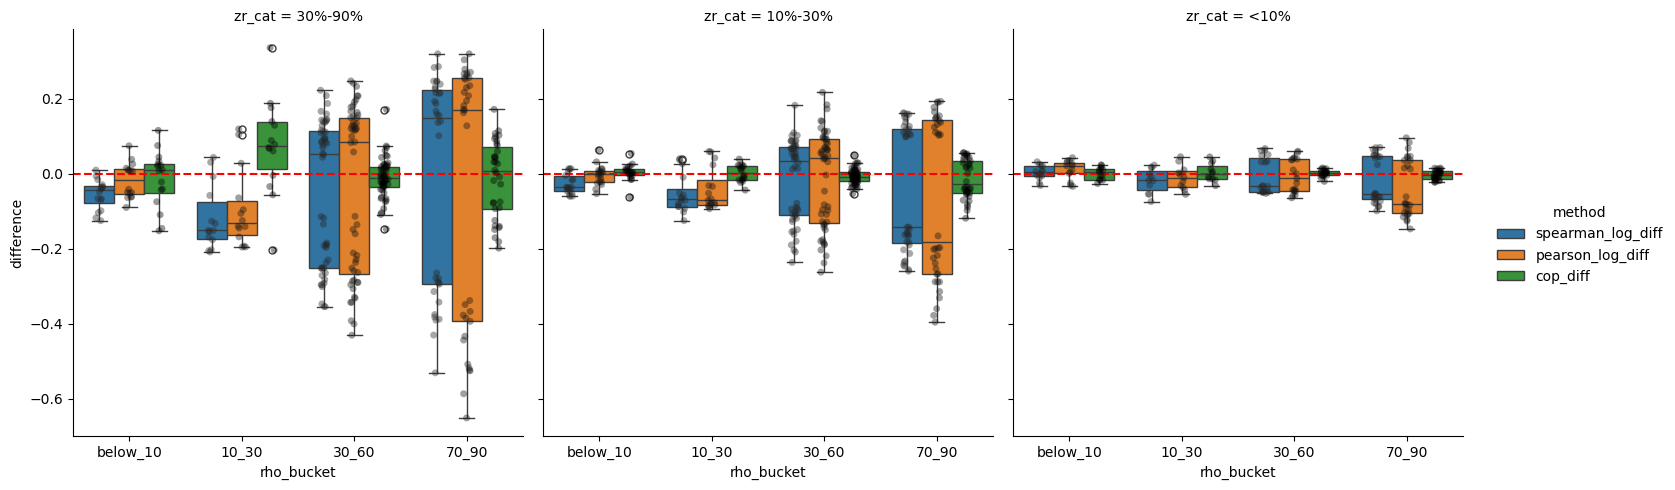

In [107]:
g = sns.catplot(data = res_focus_melt, x = 'rho_bucket', y='difference',hue="method",
            col_order = labels[::-1],
            col='zr_cat', kind='box',col_wrap=3)
g.map_dataframe(
    sns.stripplot, x = 'rho_bucket', y='difference',hue="method",
    jitter=True,
    palette='dark:black',
    alpha = 0.4,
  dodge=True,
  linewidth=0,
  edgecolor='gray'
    
)

#plt.axhline(y=0, c = 'r', linewidth = 1, linestyle='--')
# plt.savefig( os.path.join(figure_backup,
#                             'non_spatial_simulation_copula_1_24_24_coeff_bucket.pdf'), dpi = 300, bbox_inches='tight')
g.refline(y=0, color='red');

# Reproduce from the paper

In [115]:
repro_df = pd.read_csv('../orator_paper_notebook/ISMB_submission_notebooks/simulation_folder/simulated_data_with_spearman_pearson.csv')

In [121]:
import pickle
with open('../orator_paper_notebook/ISMB_submission_notebooks/simulation_folder/ismb_submission_simulated_data_24_1.pkl', 'rb') as file:
    data_list_check = pickle.load(file)

In [122]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
#opt_params = opt_params._replace(num_starts=1)

opt_res = Parallel(n_jobs=20, verbose=1)(
    delayed(model2.call_optimizer)(
        x,
        y,
        _n_array,
        _n_array,
        copula_params,
        opt_params,
        use_zero_cutoff = True,
        zero_cutoff = 0.8
    ) for (x,y,_,_,_n_array) in data_list_check)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 419 tasks      | elapsed:   13.4s
[Parallel(n_jobs=20)]: Done 461 out of 500 | elapsed:   15.2s remaining:    1.3s
[Parallel(n_jobs=20)]: Done 500 out of 500 | elapsed:   17.4s finished


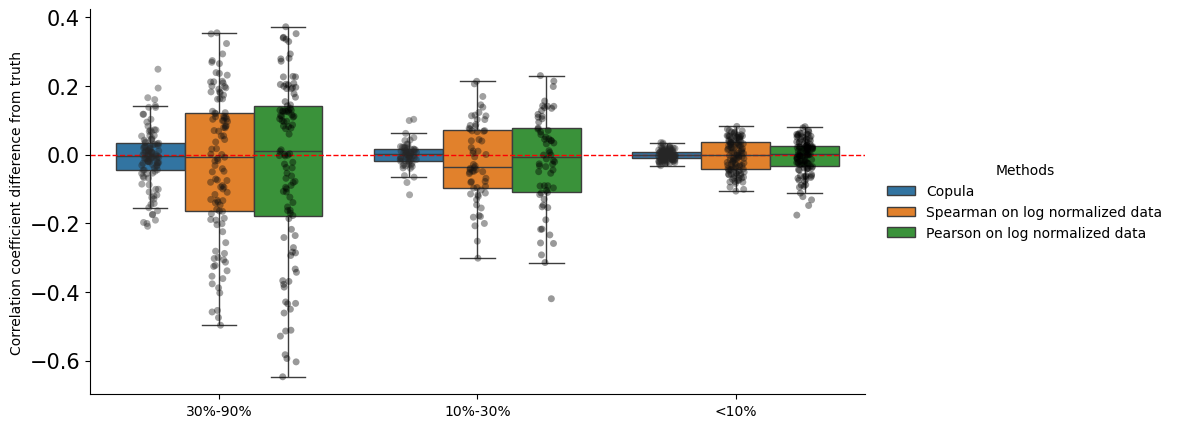

In [126]:
cop_res = [opt_res[i][0] for i in range(len(opt_res))]
repro_df.loc[:, 'cop'] = cop_res
repro_df.loc[:, 'cop_method'] = [opt_res[i][3] for i in range(len(opt_res))]
bins = [0,0.1,0.3,0.6,0.9]

# Only take where copula was run
results_filt = repro_df.loc[repro_df.cop_method == 'copula'].copy()

results_filt.loc[:, 'rho_bucket'] = pd.cut(abs(results_filt.rho), bins=bins,
                include_lowest=True,
                labels = ['<10%','10%-30%','30%-60%','70%-90%'])
bins = [0,0.1,0.3,0.9]
labels = ['<10%','10%-30%','30%-90%']
results_filt.loc[:, 'zr_cat'] = pd.cut(results_filt.zero_ratio, bins=bins,
                include_lowest=True,
                labels = labels
                )
results_filt.loc[:, 'zz_cat'] = pd.cut(results_filt.zz_ratio, bins=bins,
                include_lowest=True,
                labels = labels)


res_filt_melt = pd.melt(
    results_filt, 
    id_vars = ['rho','rho_bucket','sparse_frac','zr_cat','zz_cat'],
    value_vars = ['spearman_log', 'pearson_log' , 'cop'],
    var_name = 'method', value_name = 'value'
)

res_focus = results_filt.copy()
for col in ['spearman_log', 'pearson_log', 'cop',]:
    res_focus.loc[:, col+'_diff'] = res_focus.rho - res_focus[col]

res_focus_melt = pd.melt(
    res_focus, 
    id_vars = ['rho','rho_bucket','sparse_frac','zr_cat','zz_cat'],
    value_vars = ['spearman_log_diff', 'pearson_log_diff', 'cop_diff'],
    var_name = 'method', value_name = 'difference'
)

plt.figure(figsize=(10, 5))
#figure_backup = '/Users/hs0424/Library/CloudStorage/GoogleDrive-hiraksarkar.cs@gmail.com/My Drive/Manuscripts/2023/Orator_copulacci/ISMB_figures'

#tmp = res_df_melted.loc[res_df_melted.method.isin(['copula_diff', 'spearman_norm_diff', 'spearman_log_norm_diff'])]
label_dict = { 'cop_diff' : 'Copula', 'spearman_diff': 'Spearman', 'pearson_diff' : 'Pearson', 
              'spearman_log_diff': 'Spearman on log normalized data',
              'pearson_log_diff' : 'Pearson on log normalized data'}
sns.stripplot(x="zr_cat", y="difference", hue="method",
              data=res_focus_melt ,
              jitter=True,
              palette='dark:black',
              legend = None,
              hue_order=['cop_diff', 'spearman_log_diff', 'pearson_log_diff'],
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,
              linewidth=0,
              edgecolor='gray',
             order = labels[::-1])

sns.boxplot(x="zr_cat", y="difference", hue="method",
            data=res_focus_melt,
            #palette="Set5",
            hue_order=['cop_diff','spearman_log_diff', 'pearson_log_diff'],
            fliersize=0, 
            order = labels[::-1]
           )

plt.xlabel('', fontsize = 10)
plt.ylabel('Correlation coefficient difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=15)
plt.axhline(y=0, c = 'r', linewidth = 1, linestyle='--')


#leg = plt.gca().get_legend()
leg = plt.legend(
    title="Methods",
                 loc='right', bbox_to_anchor=(1.4,0.5),
          frameon=False);

# Replace the legend labels using the custom handler
for text, handle in zip(leg.texts, leg.legend_handles):
    text.set_text(label_dict.get(text.get_text(), text.get_text()))

plt.setp(leg.texts, fontsize='10')
sns.despine()
# plt.savefig( os.path.join(figure_backup,
#                            'non_spatial_simulation_copula_1_24_24_buckets.pdf'), dpi = 300, bbox_inches='tight')
plt.show()